In [1]:
import os
import numpy as np
import glob
from skimage.io import imread,imsave
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tensorflow as tf
import random
import tqdm
from rasterio.plot import reshape_as_image
import rasterio
from tqdm.notebook import tqdm_notebook
import yaml

In [2]:
params = yaml.safe_load(open("params.yaml"))['tfrecords_creation']

In [ ]:
image_patch = params['Image_patch_size']
mask_patch = params['Mask_patch_size']

In [ ]:
image_dataset = []
img_dir='Smaller_pond_sentinel_data_v1/Images/'
for path, subdirs, files in tqdm_notebook(os.walk(img_dir)):
    images = sorted(os.listdir(path)) 
    for i, image_name in tqdm_notebook(enumerate(images)):  
        if image_name.endswith(".tif"):
            ds = rasterio.open(path+"/"+image_name)
            image = reshape_as_image(ds.read([1,2,3]))
            print("Now patchifying image:", path+"/"+image_name)
            # creating patches with no overlaps
            patches_img = patchify(image, (image_patch), step=image_patch[0])  #Step=256 for 256 patches means no overlap
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                    image_dataset.append(single_patch_img)
images = np.array(image_dataset)

In [4]:
mask_dataset = []
mask_dir = 'Smaller_pond_sentinel_data_v1/Masks/'
for path, subdirs, files in tqdm_notebook(os.walk(mask_dir)):
    masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
    for i, mask_name in tqdm_notebook(enumerate(masks)):  
        if mask_name.endswith(".tif"):           
            mask = imread(path+"/"+mask_name,0)
            print("Now patchifying mask:", path+"/"+mask_name)
            # creating patches with no overlaps
            patches_mask = patchify(mask, (mask_patch), step=mask_patch[0])  #Step=256 for 256 patches means no overlap
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    mask_dataset.append(single_patch_mask)
masks = np.array(mask_dataset)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Now patchifying mask: /home/ubuntu/Data/Smaller pond sentinel data v1/Masks//RS_sentinel_2A_long_79.4517_lat_10.3592_2019-02-25T05_26_45.000000000_gt.tif
Now patchifying mask: /home/ubuntu/Data/Smaller pond sentinel data v1/Masks//RS_sentinel_2A_long_79.7269014_lat_11.4555343_2021-05-30T05_15_45.000000000_gt.tif
Now patchifying mask: /home/ubuntu/Data/Smaller pond sentinel data v1/Masks//RS_sentinel_2A_long_79.768401_lat_11.427475_2021-05-30T05_15_45.000000000_gt.tif
Now patchifying mask: /home/ubuntu/Data/Smaller pond sentinel data v1/Masks//RS_sentinel_2A_long_79.7966_lat_11.3297_2021-05-30T05_15_45.000000000_gt.tif
Now patchifying mask: /home/ubuntu/Data/Smaller pond sentinel data v1/Masks//RS_sentinel_2A_long_79.842153_lat_10.431728_2019-04-06T05_21_29.000000000_gt.tif
Now patchifying mask: /home/ubuntu/Data/Smaller pond sentinel data v1/Masks//RS_sentinel_2A_long_80.137293_lat_14.545728_2022-04-20T05_14_39.000000000_gt.tif
Now patchifying mask: /home/ubuntu/Data/Smaller pond senti

In [5]:
masks.shape

(1176, 256, 256)

In [6]:
images.shape

(1176, 256, 256, 3)

In [7]:
import albumentations as A

In [8]:
i=1   # variable to iterate till images_to_generate
img = []
mask1 = []
number_of_transformation = 5
while i<=(images.shape[0]): 
    number = random.randint(0, images.shape[0]-1)  #PIck a number to select an image & mask
    image = images[number]
    mask = masks[number]
    aug = A.Compose([A.RandomCrop(128,128,p=1),A.Resize(256,256)])
    augmented = aug(image=image, mask=mask)
    x1 = augmented["image"]
    y1 = augmented["mask"]

    aug = A.RandomRotate90(p=1.0)
    augmented = aug(image=image, mask=mask)
    x2 = augmented['image']
    y2 = augmented['mask']

    aug = A.GridDistortion(p=1.0)
    augmented = aug(image=image, mask=mask)
    x3 = augmented['image']
    y3 = augmented['mask']

    aug = A.HorizontalFlip(p=1.0)
    augmented = aug(image=image, mask=mask)
    x4 = augmented['image']
    y4 = augmented['mask']

    aug = A.VerticalFlip(p=1.0)
    augmented = aug(image=image, mask=mask)
    x5 = augmented['image']
    y5 = augmented['mask']
    img.append([x1,x2,x3,x4,x5])
    mask1.append([y1,y2,y3,y4,y5])
    i =i+1

newimages = np.array(img)
newmasks = np.array(mask1)

In [10]:
newimages =newimages.reshape((newimages.shape[1]*newimages.shape[0]),newimages.shape[2],newimages.shape[3],newimages.shape[4])
newmasks =newmasks.reshape((newmasks.shape[1]*newmasks.shape[0]),newmasks.shape[2],newmasks.shape[3])

In [13]:
finalimages = np.concatenate([newimages,images])
finalmasks = np.concatenate([newmasks,masks])

In [14]:
finalimages.shape

(7056, 256, 256, 3)

In [15]:
finalmasks.shape

(7056, 256, 256)

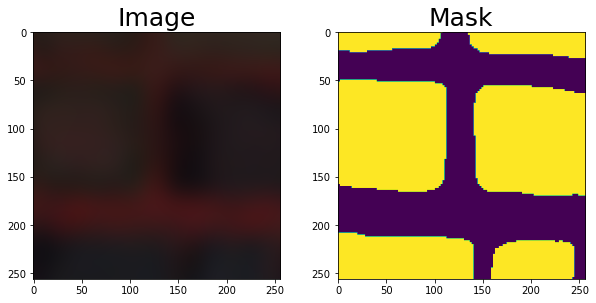

In [16]:
import random
img_number = random.randint(0, newimages.shape[0]-1)
img = newimages[img_number]
mask = newmasks[img_number]
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.title('Image',size = 25)
plt.imshow(img[:,:,0:3])
plt.subplot(2,2,2)
plt.title('Mask',size = 25)
plt.imshow(mask)
plt.show()

In [17]:
def image_example(image_string,mask):
  feature = {
      "image":tf.train.Feature(float_list=tf.train.FloatList(value=image_string.flatten())),
      "mask":tf.train.Feature(float_list=tf.train.FloatList(value=mask.flatten()))
            }

  return tf.train.Example(features=tf.train.Features(feature=feature))

In [18]:
def write_images_to_tfr_long(images,mask, filename:str="large_images", max_files:int=10, out_dir:str="/content/"):

  #determine the number of shards (single TFRecord files) we need:
  splits = (len(images)//max_files) + 1 #determine how many tfr shards are needed
  if len(images)%max_files == 0:
    splits-=1
  print(f"\nUsing {splits} shard(s) for {len(images)} files, with up to {max_files} samples per shard")

  file_count = 0

  for i in tqdm_notebook(range(splits)):
    current_shard_name = "{}{}_{}{}.tfrecords".format(out_dir, i+1, splits, filename)
    writer = tf.io.TFRecordWriter(current_shard_name)

    current_shard_count = 0
    while current_shard_count < max_files: #as long as our shard is not full
      #get the index of the file that we want to parse now
      index = i*max_files+current_shard_count
      if index == len(images): #when we have consumed the whole data, preempt generation
        break
      
      current_image = images[index]
      current_mask = mask[index]

      #create the required Example representation
      tf_example = image_example(image_string=current_image,mask=current_mask)
    
      writer.write(tf_example.SerializeToString())
      current_shard_count+=1
      file_count += 1

    writer.close()
  print(f"\nWrote {file_count} elements to TFRecord")
  return file_count

In [19]:
filename = 'tfrecords/'
os.makedirs(filename, exist_ok=True)

In [20]:
write_images_to_tfr_long(images = finalimages,mask =finalmasks, max_files=500,out_dir=filename)


Using 15 shard(s) for 7056 files, with up to 500 samples per shard


  0%|          | 0/15 [00:00<?, ?it/s]


Wrote 7056 elements to TFRecord


7056